<a href="https://colab.research.google.com/github/janchorowski/JSALT2019_tutorials/blob/master/labs/pix_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PixelCNN Lab Session

The following exercises will make you familiar with simple variants of PixelCNN. For the details consult the paper:

[van den Oord et al., Pixel Recurrent Neural Networks](http://proceedings.mlr.press/v48/oord16.pdf)

[van den Oord et al., Conditional image generation with pixelcnn decoders](https://papers.nips.cc/paper/6527-conditional-image-generation-with-pixelcnn-decoders.pdf)

Try not to spend too much time on a single task; if you find yourself stuck, ask for help!

**Make sure to set `Runtime->Change runtime type` to Python 3 and GPU.**

In [0]:
%matplotlib inline

In [0]:
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [0]:
import os
import re

import httpimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data
from torch import nn
import torch.nn.functional as F

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat
        
sns.set_style('whitegrid')

def n(t):
    return t.detach().cpu().numpy()

# Problem 1: Prepare the Data

The assignments use small, toy datasets. These could be stored entirely in the GPU memory. Below we load the `MNIST` dataset using the `InMemDataLoader` class.

As a quick warm-up:
1. Implement a generator of an artificial `Barcode` dataset of $4\times 4$ rectangular images, each with a single white vertical bar on a black background.
  * Make sure to add a small amount of Gaussian noise.
  * Although the training will be unsupervised, save aside a vector of labels (positions of white strips). We will use them during analysis of model behavior.
2. Generate train (10000) and test (1000) sets and wrap them using `InMemDataLoader`.
3. Print sample barcodes.

<img src="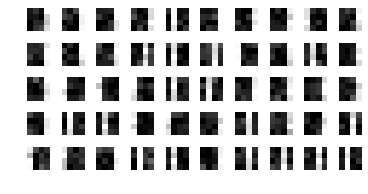
" />

In [0]:
class InMemDataLoader(object):
    """A dataloader that serves all data from GPU memory."""
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [0]:
with np.load('mnist.npz') as data:
    mnist_full_train_data = data['train_data'].astype('float32') / 255.0
    mnist_full_train_labels = data['train_labels']
    mnist_test_data = data['test_data'].astype('float32') / 255.0
    mnist_test_labels = data['test_labels']
    
    train_data = data['train_data'][:, None, :, :]
    test_data = data['test_data'][:, None, :, :]

mnist_train_loader = InMemDataLoader(
    (train_data.astype('long'), ), 
    batch_size=50, shuffle=True)

mnist_test_loader = InMemDataLoader(
    (test_data.astype('long'), ), 
    batch_size=100, shuffle=True)

batch_x, = next(iter(mnist_train_loader))
plot_mat(batch_x.numpy(), cmap='gray')

In [0]:
def gen_bars(n):
    data = 
    # TODO: Fill in the missing code
    #   - generate a (n, 1, 4, 4) tensor of barcodes
    #   - add gaussian noise
    #   - ensure pixel intensity values are in [0, 255]
    #
    return data, labels

bar_train_loader = InMemDataLoader(
    #
    # TODO: Fill in the missing code
    #
)

bar_test_loader = InMemDataLoader(
    #
    # TODO: Fill in the missing code
    #
)

In [0]:
batch_x, = next(iter(bar_train_loader))
plot_mat(batch_x.numpy(), cmap='gray')

# Problem 2: Masked Convolutions

PixelCNN uses masked convolutions to prohibit the model from looking into "future" pixels. These can be trivially implemented with `pytorch` by passing a mask tensor to an ordinary conv layer.
<center><img src="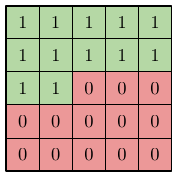
" />
</center>

1. Implement a `MaskedConv2D` layer. The data has a single grayscale channel, so the masking is simplified. It should be able to work in one of two masking modes:
  * (A) in which the central pixel cannot access its previous value,
  * (B) in which the central pixel can access its previous value.

<center><img src="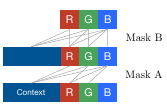
" /></center>

2. For a $k\times k$ kernel, MaskedConv2D with the above mask performs $O(k^2)$ unnecessary operations (for a single channel). This can be easily reduced to $O(k)$. *Hint: carefully study parameters of [nn.conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).*
3. Verify that your conv layers work correctly by plotting their receptive fields. Instead of tracing how the signal propagates from neighboring pixel inwards to a specific location, you can equivalently propagate it outwards from a pixel to the neighboring locations:
  * Let your image be a white square $25\times 25$ pixels with a single black pixel in the middle at $(12, 12)$ (0-indexed).
  * Apply a $5\times 5$ convolution (mask A) with kernel weights set to $1.0$; replace the image with your feature map.
  * Apply a similar convolution (mask B) a few times, every time replacing the image with the generated feature map.
  * Every subsequent application should extend the shaded area, which started as the single pixel. This is the receptive field.

For more details consult the PixelRNN paper: [van den Oord et al., Pixel recurrent neural networks](http://proceedings.mlr.press/v48/oord16.pdf) .

In [0]:
class MaskedConv2D(nn.Conv2d):
    """
    A convolution that masks pixels which ignores pixel below and to the right.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1,
                 kind='A', bias=True,):
        assert kernel_size % 2 == 1
        K2 = kernel_size // 2 + 1
        K = kernel_size
        super(MaskedConv2D, self).__init__(
            in_channels, out_channels, (kernel_size//2 + 1, kernel_size), 
            bias=bias, stride=1, padding=0, dilation=dilation)
        #
        # TODO: Fill in the missing code
        #
        self.register_buffer('mask', mask)

    def forward(self, input):
        """
        Input is N x C x H x W
        """
        dil_h, dil_w = self.dilation
        pad_h = (self.weight.size(-2) - 1) * dil_h
        pad_w = (self.weight.size(-1) // 2) * dil_w
        input = F.pad(input, [pad_w, pad_w, pad_h, 0])
        #
        # TODO: Fill in the missing code
        #

In [0]:
def plot_receptive_field(img, subplot_args):
    plt.subplot(*subplot_args)
    plt.imshow(img[0,0].detach().cpu(), cmap='Greys')
    plt.colorbar()
    plt.plot([img.size(-2)//2], [img.size(-1)//2], 'x', c='red')

def plot_conv_receptive_field(img, mask_kinds):
    nrows = (len(mask_kinds) + 4 - 1) // 4
    ncols = (len(mask_kinds) + nrows) // nrows
    plt.figure(figsize=(ncols*3, nrows*3))
    plot_receptive_field(img, (nrows, ncols, 1))
    plt.title('Original image')
    for i, kind in enumerate(mask_kinds):
        #
        # TODO: Fill in the missing code
        #
        plot_receptive_field(img, (nrows, ncols, 2 + i))
        plt.title(f'Image after conv{i} (mask {kind})')

img = torch.zeros(1, 1, 25, 25)
img[0, 0, 25//2, 25//2] = 1.0
plot_conv_receptive_field(img, 'A')
plot_conv_receptive_field(img, 'BBBBB')

# Problem 3: The Model

Start building up the PixelCNN model from its core elements.

1. Implement a `SimplePixelCNN` as a stack of `MaskedConv2d` layers. Make sure that you correctly apply type A and B masks,
2. Implement a `ResidualPixelCNN` which adds residual connections as described in the paper.
3. Train models on the `Barcode` dataset. Feel free to use/modify the training loop provided below. Plot and investigate (i.e., look intensively at) samples generated from the model during training.
  * PixelCNN outputs discreete pixel intensity values. Compare samples for the model trained with different numbers of (grayscale) output colors. Be sure to check $c=2$ and $c=256$ output colors. How do they influence the generated samples?
4. Alter the `Barcode` dataset so that one bar location (e.g., the rightmost bar) would be more probable than the others. Quickly train an auxiliary classifier to recognize the position of the bar. Do the generated samples match this property of the data?
5. Train models with bias terms added to the first conv layer:
  * a bias for every channel,
  * a bias added to every (channel, pixel). How do they influence the quality and frequency of generated samples? Why?

In [0]:
class SimplePixelCNN(nn.Module):
    def __init__(self, n_layers, kernel_size,
                 hid_channels, out_levels,
                 activation=nn.ReLU):
        in_channels = 1  # We only support single channel inputs
        super(SimplePixelCNN, self).__init__()
        self.out_levels = out_levels
        self.layers = nn.Sequential()
        #
        # TODO: Fill in the missing code
        #
    
    def forward(self, input):
        """
        input has shape N x 1 x W x H
        output has shape N x out_levels x W x H
        """
        return self.layers(input)


class ResidualPixelCNN(nn.Module):
    def __init__(self, n_layers=7, out_n_layers=2, hid_channels=32, out_levels=256,
                 in_kernel_size=7, kernel_size=3, in_bias_size=1):
        in_channels = 1  # We only support single channel inputs
        super(ResidualPixelCNN, self).__init__()
        self.out_levels = out_levels
        
        # Add an additional bias (only to the output of the first convolution)
        # This bias should be either per channel, or per (channel, pixel).
        self.bias = nn.Parameter(
            #
            # TODO: Fill in the missing code
            #
        )

        #
        # TODO: Fill in the missing code
        #
    
    def forward(self, x):
        """
        input has shape N x 1 x W x H
        output has shape N x out_levels x W x H
        """
        res = self.in_to_res(x) + self.bias
        #
        # TODO: Fill in the missing code
        #
        return res

      
def plot_samples(h, w, out_levels, figsize=(2,4)):
    img = torch.zeros(8, 1, h, w).cuda().requires_grad_(False)

    for r in range(h):
        for c in range(w):
            logits = model(img)     
            values = torch.multinomial(torch.softmax(logits[:, :, r, c], 1), 1)
            img[:, 0, r, c] = values.float().squeeze(1) / (out_levels - 1)
    
    plt.figure(figsize=figsize)
    plot_mat(img.detach().cpu().numpy(), scaleIndividual=False, cmap='viridis')
    plt.show()

In [0]:
def train(model, train_loader, test_loader, num_epochs=5, lr=5e-3):
    try:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        global_step = 0

        model.to('cuda')
        train_loader.to('cuda')
        test_loader.to('cuda')

        for epoch in range(num_epochs):
            model.train()
            for inum, (batch_x,) in enumerate(train_loader):
                targets = batch_x // (256 / model.out_levels)
                inputs = targets.float() / (model.out_levels - 1)
                global_step += 1
                optimizer.zero_grad()
                logits = model(inputs)
                loss = F.cross_entropy(logits, targets.squeeze(1))
                loss.backward()
                optimizer.step()
                loss = loss.item()
                
                bits_per_pixel =   # TODO: Fill in the missing code
                
                if global_step and (global_step%100) == 0:
                    print(f"Step: {global_step: 6} | "
                          f"lr {optimizer.param_groups[0]['lr']: 8.5f} | "
                          f"loss: {loss: 6.3f} | bits/pixel {bits_per_pixel: 6.3f}")

            model.eval()
            with torch.no_grad():
                plot_samples(batch_x.size(2), batch_x.size(3), model.out_levels)
                tot_loss = 0
                tot_examples = 0
                for (batch_x,) in test_loader:
                    targets = batch_x // (256 / model.out_levels)
                    inputs = targets.float() / (model.out_levels - 1)
                    logits = model(inputs)
                    tot_loss += F.cross_entropy(logits, targets.squeeze(1)).item() * batch_x.size(0)
                    tot_examples += batch_x.size(0)
                loss = tot_loss / tot_examples

                bits_per_pixel =   # TODO: Fill in the missing code
                
                print(f"Epoch {epoch: 3} ended. Test loss: {loss: 6.3f} | "
                      f"bits/pixel {bits_per_pixel: 6.3f}")
                scheduler.step(loss)
    except KeyboardInterrupt:  # Handles 'stop' button in the notebook
        print('-- training stopped --')

In [0]:
# Train a classifier
from sklearn.linear_model import LogisticRegression
#
# TODO: Fill in the missing code
#
classifier = 
score = 
print(f'Accuracy: {score*100.0}')

p = np.histogram(bar_labels_y, bins=range(5), density=True)[0] * 100.0
print('Class distribution in the data: ', ' '.join([f'{v:.2f}%' for v in p]))

def class_distribution(model, h=4, w=4, n=1000):
    #
    # TODO: Fill in the missing code
    #
    p = 
    print('Class distribution: ', ' '.join([f'{v:.2f}%' for v in p]))

In [0]:
# TODO: Declare the model and run training
model = 
train(model, bar_train_loader, bar_test_loader)

In [0]:
class_distribution(model)

In [0]:
# TODO: Run with different parameters. Lather, rinse, repeat.
model = 
train(model, bar_train_loader, bar_test_loader)

In [0]:
class_distribution(model)

# Problem 4: MNIST Training

1. Train a `ResidualPixelCNN` model on the `MNIST` dataset (do not aim for the perfect parametrs; a couple minutes of training should yield an interesting model).
2. Compute and report NLL on `MNIST` train and test sets.
3. Implement the remaining improvements to your model, which are described in the PixelCNN paper. Check NLL and the subjective quality of generated samples.
  * Gated activations $\mathbf{y} = tanh(W_{k,f} * \mathbf{x}) \odot \sigma(W_{k,g} * \mathbf{X})$, where $W_{k,f}$ and $W_{k,g}$ are convolutions producing features and gate weights.
  * Horizonal and vertical convolutions, which fully extend the receptive field.

In [0]:
model = 
train(mnist_train_loader, mnist_test_loader, num_epochs=20)

In [0]:
class GatedMConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 #cond_channels=(), stride=1, dilation=1, groups=1,
                 bias=True, kind='A', act='tanh'):
        super(GatedMConv2D, self).__init__()
        self.out_chanels = out_channels
        self.conv = MaskedConv2D(
            in_channels, out_channels * 2, kernel_size, kind=kind,
            bias=bias)
        self.act = getattr(torch, act)

    def forward(self, x):  # , conds):
        """
        x: N x C x T
        conds: list of N x CC x T/k
        """
        #
        # TODO: Fill in the missing code.
        #
        
      
class ResidualGatedPixelCNN(nn.Module):
    def __init__(self, num_layers, num_output_layers, kernel_size,
                 res_channels, hid_channels, skip_channels, out_levels,
                 dropout=0.0, activation=nn.ReLU):
        in_channels = 1  # We only support single channel inputs
        super(ResidualGatedPixelCNN, self).__init__()
        #
        # TODO: Fill in the missing code.
        #

    def forward(self, x): #, conds=()):
        """
        x: BS x Dim x T
        conds: list of BS x DimC x T/k
        """
        #
        # TODO: Fill in the missing code.
        #

# Problem 5: Extras

Congratulations for completing the assignments!

As an extra exercise, you might either:
* Implement one of the recurrent models (RowLSTM or Diagonal BiLSTM) and compare its performance on MNIST with PixelRNN models.
* Try training a simple CIFAR-10 model, making sure that your masking handles `RGB` channels properly. Note that training a good model might take quite some GPU time. CIFAR-10 data gets downloaded in the first section of this notebook.